# Kaggle Courses - Computer Vision
## 01. 합성곱 분류자
캐글 코스의 컴퓨터 비전 강의를 번역 및 정리한 내용입니다.  
by. yhee3000

# 소개
컴퓨터 비전 분야의 가장 근본적인 목표는 인간의 시각 인지 능력에 버금가는 인공신경망 프로그램을 만드는 것이다. 즉, **인공신경망이 인간만큼 자연 상태의 이미지를 잘 '이해할 수 있도록'** 하는 것이다.  
  
이런 목표를 가장 잘 수행할 수 있는 신경망 네트워크는 '**합성곱 신경망 네트워크(Convolutional Neural Networks, ConvNet, CNN)**'이다. 여기서 합성곱은 ConvNet이 가지는 특수한 구조를 설명하는 수학적 계산 과정이다. 이 합성곱 구조가 왜 이미지 처리에 적합한지는 나중에 살펴볼 것이다.  
  
이제 **이미지 분류(image classification)** 문제에 합성곱 신경망을 적용해보자. 사진 속 식물을 분류하는 앱과 같은 서비스가 이미지 분류자(image classifier)이다. 이 코스에선 실제로 사용되는 분류자만큼 효과가 좋은 분류자를 만들어 볼 것이다.  

이미지 분류에 더 많은 비중을 두고 설명을 할 것이지만, 이 코스의 내용은 모든 컴퓨터 비전 문제를 해결하는데에 도움이 된다. 끝에 다다를때면 '생산적 적대 신경망(Generative Adversarial Networks)'과 '이미지 분할(image segmentation)'처럼 보다 어려운 곳에 적용할 수 있을 것이다.

# 합성곱 분류자
이미지 분류를 위해 사용되는 ConvNet은 두 개의 요소를 가진다   
: 합성곱 베이스(convolutional base)와 밀집한 헤드(dense head) 
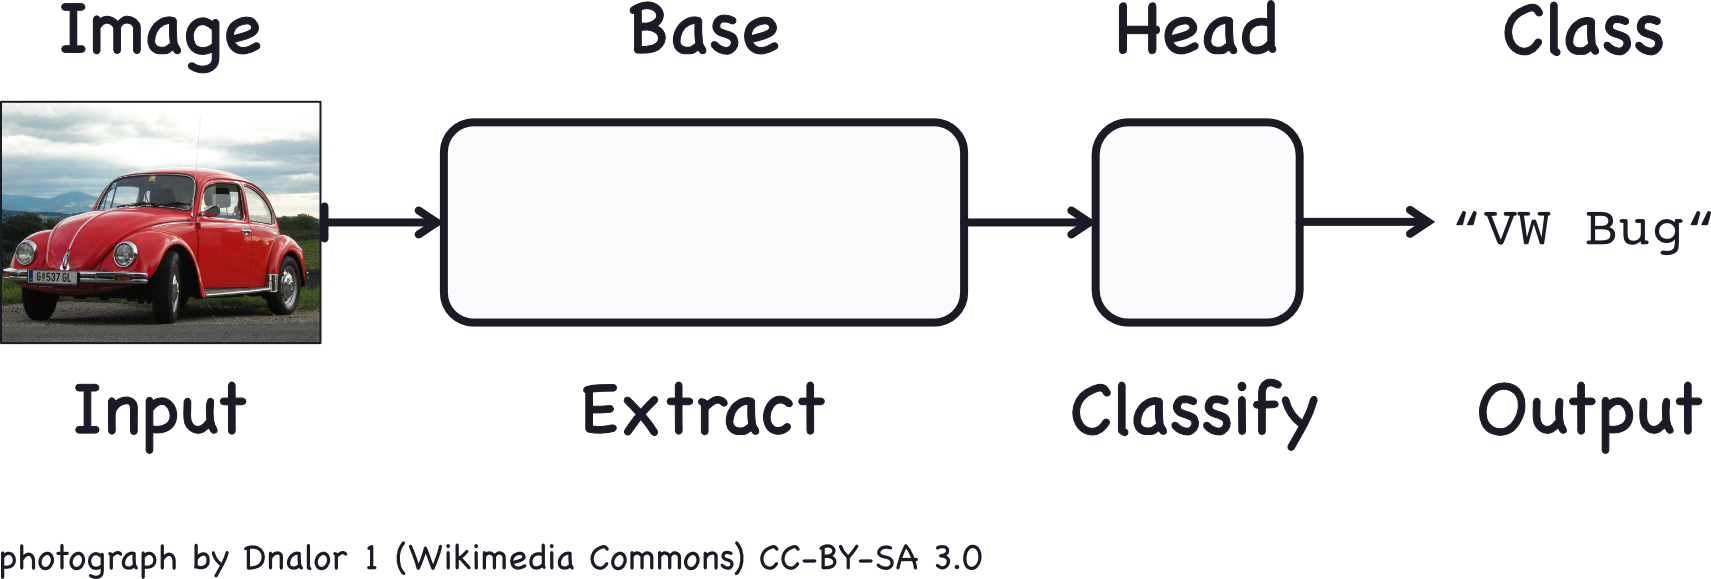
  
* **베이스 : 이미지의 특성(feature)를 추출하기 위함.**   
대부분 합성곱 계산을 하는 레이어로 이루어지지만 다른 레이어도 포함된다.  
* **헤드 : 이미지에서 클래스(레이블)를 결정하기 위함.**   
대부분 밀집한 레이어(dense layer)로 이루어지지만 드롭아웃과 같은 다른 레이어도 포함할 수 있다.   
  
여기서 시각적 '특성'은 무엇을 의미할까? 특성(feature)은 선, 색, 모양, 패턴 또는 다른 복잡한 요소가 될 수 있다.  
  
따라서 이미지 분류의 전체 과정은 아래와 같다.
1. 이미지에서 특성을 추출하고 (베이스)  
2. 특성을 바탕으로 클래스를 결정하여 (헤드)  
3. 최종 결과를 도출

# 분류자 훈련시키기
  
학습 과정에서 네트워크가 배워야 할 것은 두 가지이다.
* 이미지에서 어떤 특성을 추출할지 (베이스)
* 특정한 특성이 어떤 클래스와 연관있는지 (헤드) 
  
요즘의 ConvNet은 처음부터 짜여지는 경우가 거의 없다. 대부분 '미리 훈련된(pre-trained)' 모델의 베이스를 재활용한다. 이 베이스에 훈련되지 않은 헤드를 붙여서 사용한다. 즉, 특성을 추출하는 부분은 이미 훈련된 모델을 가져와 재활용하고 클래스를 분류하는 부분은 새롭게 레이어를 만드는 것이다.   
  
헤드는 대부분 몇 개의 밀접한 레이어로만 이루어져 있기에 상대적으로 적은 양의 데이터로도 정확한 분류자를 만들어낼 수 있다.  
  
미리 훈련된 모델을 재활용하는 기법은 '**전이 학습(transfer learning)**'이라고 한다. 대부분의 이미지 분류자들은 이 방법을 사용한다.

# 예시- 합성곱 분류자 훈련시키기
예제를 통해 해결할 문제는 특정 이미지가 '차(car)'인지 '트럭(truck)'인지 구별하는 문제이다. 사용할 데이터셋은 반은 차, 반은 트럭인 10,000개의 이미지로 이루어진다.

### Step 1 - 데이터 불러오기 

필요한 라이브러리를 불러오고 데이터 파이프라인을 구축한다.   
학습에 사용할 데이터를 ds_train, 검증에 사용할 데이터를 ds_valid라고 저장한다.

In [ ]:
# 라이브러리 불러오기
import os, warnings # os: 운영체제 제어(파일/폴더 만들고 복사하기), warnings: 경고 제어
import matplotlib.pyplot as plt # matplotlib 패키지 중 그래프를 그릴 수 있는 pyplot 모듈
from matplotlib import gridspec  # gridspec: 다중 플롯

import numpy as np # numpy: 벡터/행렬 연산에 용이한 라이브러리
import tensorflow as tf  # tensorflow: 데이터 흐름 프로그래밍을 위한 라이브러리
from tensorflow.keras.preprocessing import image_dataset_from_directory

# 랜덤 시드 
# : 컴퓨터 프로그램에서의 '랜덤' 수는 실제로 랜덤하지 않고, 시작 숫자를 정해주면 컴퓨터가 정해진
# 알고리즘에 의해 랜덤으로 보이는 수열을 생성. 이 '시작 숫자'가 '시드(seed)'
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Matplotlib 조건 설정
# : plt.rc()를 통하면 경고 메세지 없이 기본 설정을 변경할 수 있음
plt.rc('figure', autolayout = True)
plt.rc('axes', labelweight = 'bold',labelsize = 'large', 
       titleweight = 'bold', titlesize = 18, titlepad = 10)
plt.rc('image', cmap = 'magma')
warnings.filterwarnings('ignore')

# 훈련/검증 데이터셋 불러오기
# image_dataset_from_directory: 디렉토리 내 이미지 파일로 tf.data.Dataset 생성
ds_train_ = image_dataset_from_directory('../input/car-or-truck/train',
                                    labels = 'inferred',
                                    # inferred: 디렉토리 구조로 레이블 예측
                                    label_mode = 'binary', 
                                    # binary: 레이블이 0 또는 1의 float32 스칼라값으로 인코딩
                                    image_size = [128,128],
                                    interpolation = 'nearest',
                                    batch_size = 64,
                                    shuffle = True)

ds_valid_ = image_dataset_from_directory('../input/car-or-truck/valid',
                                    labels = 'inferred',
                                    label_mode = 'binary',
                                    image_size = [128,128],
                                    interpolation = 'nearest',
                                    batch_size = 64,
                                    shuffle = False)

# 데이터 파이프라인
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype = tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE 

ds_train = ds_train_.map(convert_to_float).cache().prefetch(buffer_size = AUTOTUNE)
ds_valid = ds_valid_.map(convert_to_float).cache().prefetch(buffer_size = AUTOTUNE)

''' 
tf.data.Dataset.prefetch 
= 백그라운드 스레드 & 내부 버퍼를 통해 요청된 시간 전에 입력 데이터셋에서 데이터를 가져옴
    - 가져올 데이터 수는 >= (한 번의 훈련에서) 소비한 배치의 수
    - tf.data.experimental.AUTOTUNE으로 설정하면 tf.data 런타임이 실행 시에 동적으로 값을 조정함
            
tf.data.Dataset.map
= 사용자 정의 함수를 데이터셋의 각 데이터에 적용

tf.data.Dataset.cache
= 데이터셋을 메모리/로컬 저장소에 저장 (각 런타임이 실행되는 동안의 일부 작업을 저장)
'''

### Step 2 - 사전 학습된 베이스 정의하기   

흔히 사전 학습을 위해 사용하는 데이터셋은 'ImageNet'이다.  
Keras의 applications 모듈에는 ImageNet에 대해 사전 학습된 다양한 모델이 있다.  
예시에서 사용할 사전 학습된 모델은 VGG16이다.

In [ ]:
pretrained_base = tf.keras.models.load_model(
    '../input/cv-course-models/cv-course-models/vgg16-pretrained-base')
# .load_model : 사전 학습되어 저장된 모델을 불러옴

pretrained_base.trainable = False 

### Step 3 - 헤드 연결하기    

그 다음엔 분류자 헤드(classifier head)를 연결한다.  
이 예시에서는 히든 레이어(첫 번째 Dense 레이어)와  
출력값을 클래스 1인 Truck에 대한 확률 스코어로 변환하는 레이어를 사용한다.  
Flatten 레이어는 베이스의 2차원 출력값을 헤드가 필요로 하는 1차원 입력값으로 변환한다.

In [ ]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

### Step 4 - 훈련하기    

마지막으로 모델을 훈련시키자.  
클래스가 2개인 문제이므로, crossentropy와 accuracy를 이진 버젼으로 사용한다.  
adam 최적화는 대부분 잘 작동하므로, 이번 예시에서도 이를 사용한다.

In [ ]:
# 모델을 학습시키기 전, compile() 메소드로 학습 방식에 대한 환경 설정
model.compile(
    optimizer = 'adam',  # 최적화 방법
    loss = 'binary_crossentropy', # 오차 계산 방법(손실 함수)
    metrics = ['binary_accuracy'] # 기준(metric) 리스트 : 분류 문제는 accuracy로 지정함
)

# 모델 학습시키기 fit()
history = model.fit(
    ds_train, # 훈련 데이터
    validation_data = ds_valid, # 검증 데이터 
    epochs = 30  # 훈련 횟수(epoch)
)

신경망을 학습시킬 땐, 항상 오차(loss)와 기준(metric)을 그래프를 그려 확인하는 것이 좋다.  
history 객체는 이 정보를 history.history 딕셔너리에 저장한다.   
Pandas를 사용하여 이 딕셔너리를 데이터프레임으로 전환하여 내장된 방법으로 그래프를 그릴 수 있다.

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)  # 오차와 기준 정보를 데이터프레임으로 전환
# 그래프 1 : 가로축 epoch, 세로축 loss(훈련 오차) & val_loss(검증 오차)
history_frame.loc[:, ['loss','val_loss']].plot()
# 그래프 2 : 가로축 epoch, 세로축 binary_accuracy(훈련 정확도) & val_binary_accuracy(검증 정확도)
history_frame.loc[:, ['binary_accuracy','val_binary_accuracy']].plot()

# 결론  
첫 번째 레슨에서는 ConvNet 분류자의 구조를 알 수 있었다 : (이미지) 특성을 추출하는 베이스(base)와 실제 분류 작업을 하는 헤드(head).  
  
헤드는 일반적인 분류자와 같다. 특성들은 베이스로부터 얻을 수 있다. 이렇게 분류자 자체에 특성 공학(feature engineering)을 적용하는 요소(unit)를 직접 더할 수 있다는 것이 합성곱 분류자의 기본적인 아이디어이다.   
  
즉, 올바른 네트워크 구조를 가지면 딥신경망은 해당 문제(ex. 분류)를 해결하기 위해 특성을 조절할 수 있다. 이것이 기존 머신러닝 모델과 비교하여 딥신경망 구조들이 가지는 가장 큰 장점 중 하나이다. 